# Vaccine Tweets Geological Data Exploration

* Authors: 
    * Kai Watanabe 
    * Yueshuwei Wu
* Description:
    <br/> This time's data exploration analysis will focus on the geological distribution of the tweets we have. We first used the geotext library to extract user's geographical inofrmation from provided descriptions. Based on the distribution of users' locations, we picked New York, Chicago and Los Angeles to futher investigate the connection between tweeting behavior and city/county's race profile.

## Importing Dataset From Kaggle

* Since this Pfizer Vaccine Tweets dataset is continually updating, we want to pull the dataset directly from Kaggle using the provided API.
* To use the Kaggle API, you need to do the following:
    * Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens.
    * Click on Create New API Token - It will download kaggle.json file on your machine.
    * now just put it in the location C:\Users\(your user name)\.kaggle.

In [162]:
# uncomment the next line if you are running this notebook on a local machine.
#!pip install kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
from zipfile import ZipFile
api = KaggleApi()
api.authenticate()
api.dataset_download_files('gpreda/pfizer-vaccine-tweets')

# Access the dataset just download.
zf = ZipFile('pfizer-vaccine-tweets.zip')
#extracted data is saved in the same directory as notebook
zf.extractall() 
zf.close()

## Data pre-processing
### Import Tools

In [163]:
import pandas as pd

### Load the dataset, check variable names and amount of data points.

In [164]:
df_tweets = pd.read_csv('vaccination_tweets.csv',dtype={ 'user_location':str})
print(df_tweets.columns)
print(df_tweets.shape)

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],
      dtype='object')
(4560, 16)


### Cleaning
<br/> Now we drop the columns that we will not use for this assignment. This cell may be modified for future needs.

In [165]:
df_tweets.drop(columns=['user_description','hashtags'], inplace=True)
print(df_tweets.columns)
print(df_tweets.shape)

Index(['id', 'user_name', 'user_location', 'user_created', 'user_followers',
       'user_friends', 'user_favourites', 'user_verified', 'date', 'text',
       'source', 'retweets', 'favorites', 'is_retweet'],
      dtype='object')
(4560, 14)


## Extracting user's locations.
Some users had proveded descriptions about their location but not necessarily the exact address. We want to at least extract the city and country information of the user. To accomplish this task, we will us a library call Geotext.This library allow us to extract city name and country code without going through the NLP hassle. The geological information will be used to guide the direction of this research. 
### Import GeoText

In [166]:
!pip install geotext
from geotext import GeoText

### How GeoText works?

In [167]:
# must import the method in next line to extract keys from ordered dictionary
from collections import OrderedDict 
places1 = GeoText("my bed")
print(places1.cities)
# prints empty list []
places2 = GeoText("London is a great city")
print(places2.cities)
# prints ['London']
print(list(places2.country_mentions.keys())[0])
print("tada!")

[]
['London']
GB
tada!


To make full use of it, we need to import one more library

In [168]:
from collections import OrderedDict 
od = OrderedDict() 
od['a'] = 1
od['b'] = 2
od['c'] = 3
od['d'] = 4
print(od.keys())

odict_keys(['a', 'b', 'c', 'd'])


### Further cleaning
Since we cannot extract locations from numbers or null entries we should drop the rows that user_location is not string. It's okay to have empty string as location description, Geotext will figure it out. 
<br/> This cell is optional, you can specify the location description to be string when loading the dataset. But if the location description is not string, then that row is likely to cause error later.

In [169]:
indexes_to_drop = []
for index, row in df_tweets.iterrows():
    if type(row['user_location']) is not str:
        indexes_to_drop.append(df_tweets.index[index])
    
df_tweets.drop(indexes_to_drop, inplace=True)
df_tweets.shape

(3626, 14)

We lost about 900 data points, but we still have about 3626 left.
### Finally, extracting location data
<br/>Next we will extract and assign the city names to the each data point.

In [170]:
from collections import OrderedDict 
user_city = []
user_country = []
for index, row in df_tweets.iterrows():
    if GeoText(row['user_location']).cities:
        user_city.append(GeoText(row['user_location']).cities[0])
        user_country.append(list(GeoText(row['user_location']).country_mentions.keys())[0])
    else:
        user_city.append('')
        user_country.append('')

df_tweets['user_city'] = user_city
df_tweets['user_country'] = user_country

## Analysis
### Number of tweets per location
We want to see which cities' users are more likely to tweet about the vaccines. This can be done by appling the value_count() method.

In [171]:
df_tweets['user_city'].value_counts().to_frame().head(10)

,user_city
,1804
London,170
Dubai,59
New York,50
New Delhi,46
Toronto,40
Mumbai,39
Watford,37
Glasgow,37
Cornwall,35


Repeat the same procedure for countries.

In [172]:
df_tweets['user_country'].value_counts().to_frame().head(10)

,user_country
,1804
US,717
GB,397
IN,162
CA,147
AE,67
DE,32
IE,30
ZA,24
PH,22



We can see that majority of tweets are from the United States (US) and the United Kingdom (GB). Another interesting observation is that more than one third of the UK tweets are from London, whereas the US tweets has a more "sparse" geographical distribution. The city that contributed most to the US tweets is New York, which contributed less than 10% of the US tweets. 
### User contributions
The next step is to check if any user contributed significantly to the total counts.

In [173]:
frequent_tweeters = df_tweets['user_name'].value_counts().head(15).to_frame().reset_index()
frequent_tweeters.columns = ['user_name', 'count']
frequent_tweeters.head(5)

,user_name,count
0,Ian 3.5% #FBPE,33
1,Whtrslugcaviiersong#dontstayhomeandcatchcovid19,30
2,Simon Hodes ⬅️2m➡️ 😷,30
3,TheRag,29
4,ILKHA,29


Now let's find out where are these user tweeting from so we can consider which cities will not be investigated.

In [174]:
cities = []
countries = []
for index, row in df_tweets.iterrows():
    if row['user_name'] in list(frequent_tweeters['user_name']):
        if row['user_city'] and row['user_country']:
            cities.append(row['user_city'])
            countries.append(row['user_country'])
pairs = {'city': cities , 'country': countries}
df = pd.DataFrame(pairs)
df.groupby('country')['city'].value_counts()

country  city    
AE       Dubai       13
CA       Cornwall    33
GB       Watford     30
         Glasgow     20
Name: city, dtype: int64

We can see these users contributed the majority of tweets from Cornwall Watford and Glasgow. we may study more closely what are they tweeting later, but for now we will exclude these cities from our study.

### What to investigate?
Notice US users contributed nearly one fifth of the tweets, we want to take a look at the cities that cares most about vaccine. We also want to see what makes them stand out and possible reasons behind this. Taking the information above in to consideration, we decided to further investigate the differences of race profiles amoung those top tweeted cities.

We firts seperate the US users from the dataset. we should have 717 data points.

In [175]:
df_UStweets = df_tweets.query("user_country == 'US'")
df_UStweets.shape

(717, 16)

Now we want to pick the cities we want to study, a value count will help us make our decision.

In [176]:
df_UStweets['user_city'].value_counts().to_frame().head(6)

,user_city
New York,49
Chicago,28
Atlanta,22
Boston,21
Birmingham,20
Los Angeles,19


We observed that New York city and Chicago city has signifant more tweets than others. The rest of the cities on the list seems all have tweets around 20. Thus, for simplicity, we will analyze the race profiles of New York, Chicago and Los Angeles. This will be done by introducing the census data.	

### Using Census data
Load the data, add blocks to solve the leading zero dilemma.

In [177]:
df_NY = pd.read_csv('Cities/New York County Race.csv',
                   dtype=
                    {
                        'Geo_FIPS':str,
                        'Geo_STATE':str,
                        'Geo_COUNTY': str
                    })
df_CH = pd.read_csv('Cities/Chicago Race.csv',
                   dtype=
                    {
                        'Geo_FIPS':str,
                        'Geo_STATE':str,
                        'Geo_COUNTY': str
                    })
df_LA = pd.read_csv('Cities/LA County Race.csv',
                   dtype=
                    {
                        'Geo_FIPS':str,
                        'Geo_STATE':str,
                        'Geo_COUNTY': str
                    })

Confirm that our new dataframe has the correct datatypes.The zeros should be non-zero strings now.

In [178]:
print(df_NY.info(verbose=True, null_counts=True))
print(df_CH.info(verbose=True, null_counts=True))
print(df_LA.info(verbose=True, null_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 70 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Geo_FIPS           288 non-null    object 
 1   Geo_GEOID          288 non-null    object 
 2   Geo_NAME           288 non-null    object 
 3   Geo_QName          288 non-null    object 
 4   Geo_STUSAB         288 non-null    object 
 5   Geo_SUMLEV         288 non-null    int64  
 6   Geo_GEOCOMP        288 non-null    int64  
 7   Geo_FILEID         288 non-null    object 
 8   Geo_LOGRECNO       288 non-null    int64  
 9   Geo_US             0 non-null      float64
 10  Geo_REGION         0 non-null      float64
 11  Geo_DIVISION       0 non-null      float64
 12  Geo_STATECE        0 non-null      float64
 13  Geo_STATE          288 non-null    object 
 14  Geo_COUNTY         288 non-null    object 
 15  Geo_COUSUB         0 non-null      float64
 16  Geo_PLACE          0 non-n

<ipython-input-178-9ccd5a7b06ff>:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  print(df_NY.info(verbose=True, null_counts=True))
<ipython-input-178-9ccd5a7b06ff>:2: FutureWarning: null_counts is deprecated. Use show_counts instead
  print(df_CH.info(verbose=True, null_counts=True))
<ipython-input-178-9ccd5a7b06ff>:3: FutureWarning: null_counts is deprecated. Use show_counts instead
  print(df_LA.info(verbose=True, null_counts=True))


Now we drop all the null columns and compare with the results in last cell.

In [179]:
df_NY = df_NY.dropna(axis=1,how="all")
df_CH = df_CH.dropna(axis=1,how="all")
df_LA = df_LA.dropna(axis=1,how="all")
print(df_NY.info(verbose=True, null_counts=True))
print(df_CH.info(verbose=True, null_counts=True))
print(df_LA.info(verbose=True, null_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Geo_FIPS           288 non-null    object 
 1   Geo_GEOID          288 non-null    object 
 2   Geo_NAME           288 non-null    object 
 3   Geo_QName          288 non-null    object 
 4   Geo_STUSAB         288 non-null    object 
 5   Geo_SUMLEV         288 non-null    int64  
 6   Geo_GEOCOMP        288 non-null    int64  
 7   Geo_FILEID         288 non-null    object 
 8   Geo_LOGRECNO       288 non-null    int64  
 9   Geo_STATE          288 non-null    object 
 10  Geo_COUNTY         288 non-null    object 
 11  Geo_TRACT          288 non-null    int64  
 12  SE_A03001_001      288 non-null    int64  
 13  SE_A03001_002      288 non-null    int64  
 14  SE_A03001_003      288 non-null    int64  
 15  SE_A03001_004      288 non-null    int64  
 16  SE_A03001_005      288 non

<ipython-input-179-75ece186acd8>:4: FutureWarning: null_counts is deprecated. Use show_counts instead
  print(df_NY.info(verbose=True, null_counts=True))
<ipython-input-179-75ece186acd8>:5: FutureWarning: null_counts is deprecated. Use show_counts instead
  print(df_CH.info(verbose=True, null_counts=True))
<ipython-input-179-75ece186acd8>:6: FutureWarning: null_counts is deprecated. Use show_counts instead
  print(df_LA.info(verbose=True, null_counts=True))


We used to have to 70 columns but now we reduced it to 27 columns.
<br />  The next step is to drop columns we will not use.

In [180]:
columns_to_drop = ['Geo_GEOID','Geo_STUSAB','Geo_SUMLEV','Geo_GEOCOMP','Geo_FILEID','Geo_LOGRECNO']
df_NY = df_NY.drop(columns_to_drop,axis=1)
df_CH = df_CH.drop(columns_to_drop,axis=1)
df_LA = df_LA.drop(columns_to_drop,axis=1)

We want to check the column names and make sure they are easy to use.

In [181]:
# only print once since they are subset of the same dataset
print(df_NY.columns.to_list())

['Geo_FIPS', 'Geo_NAME', 'Geo_QName', 'Geo_STATE', 'Geo_COUNTY', 'Geo_TRACT', 'SE_A03001_001', 'SE_A03001_002', 'SE_A03001_003', 'SE_A03001_004', 'SE_A03001_005', 'SE_A03001_006', 'SE_A03001_007', 'SE_A03001_008', 'PCT_SE_A03001_002', 'PCT_SE_A03001_003', 'PCT_SE_A03001_004', 'PCT_SE_A03001_005', 'PCT_SE_A03001_006', 'PCT_SE_A03001_007', 'PCT_SE_A03001_008']


Obviously the variable names are not easy to use, we will change them.

In [182]:
names = ['FIPS',
 'Geo_NAME',
 'Geo_QName',
 'Geo_STATE',
 'Geo_COUNTY',
 'Geo_TRACT',
 'TotalPop',
 'White',
 'Black',
 'AmIndian_AlaskaNative',
 'Asian',
 'Haw_PI',
 'Other',
 'Two_or_more',
 'PCT_White',
 'PCT_Black',
 'PCT_AmIndian_AlaskaNative',
 'PCT_Asian',
 'PCT_Haw_PI',
 'PCT_Other',
 'PCT_Two_or_more']
df_NY.columns = names
df_CH.columns = names
df_LA.columns = names

Now we drop the tracks that population equals to zero.

In [183]:
df_NY = df_NY.query("TotalPop > 0")
df_CH = df_CH.query("TotalPop > 0")
df_LA = df_LA.query("TotalPop > 0")

Asian: 14.60011645845862 %
White: 67.70399872527186 %
Black: 17.695884816269526 %


<AxesSubplot:ylabel='Frequency'>

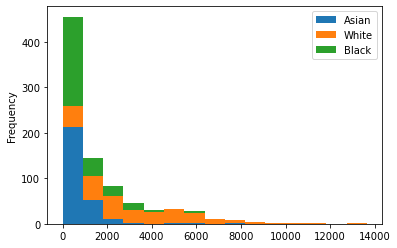

In [184]:
summ = df_NY['Asian'].mean() + df_NY['White'].mean() + df_NY['Black'].mean()
print('Asian:',df_NY['Asian'].mean()/summ*100,'%')
print('White:',df_NY['White'].mean()/summ*100,'%')
print('Black:',df_NY['Black'].mean()/summ*100,'%')
df_NY[['Asian','White','Black']].plot.hist(stacked=True,bins=15)

Asian: 8.351958344540622 %
White: 64.85144526711942 %
Black: 26.796596388339957 %


<AxesSubplot:ylabel='Frequency'>

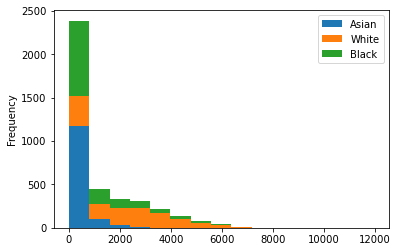

In [185]:
summ = df_CH['Asian'].mean() + df_CH['White'].mean() + df_CH['Black'].mean()
print('Asian:',df_CH['Asian'].mean()/summ*100,'%')
print('White:',df_CH['White'].mean()/summ*100,'%')
print('Black:',df_CH['Black'].mean()/summ*100,'%')
df_CH[['Asian','White','Black']].plot.hist(stacked=True,bins=15)

Asian: 19.742602057157317 %
White: 69.26219040055791 %
Black: 10.995207542284776 %


<AxesSubplot:ylabel='Frequency'>

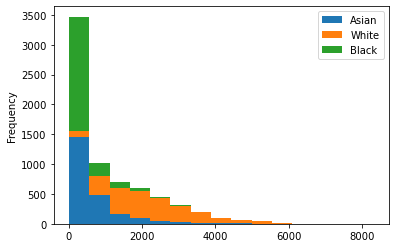

In [186]:
summ = df_LA['Asian'].mean() + df_LA['White'].mean() + df_LA['Black'].mean()
print('Asian:',df_LA['Asian'].mean()/summ*100,'%')
print('White:',df_LA['White'].mean()/summ*100,'%')
print('Black:',df_LA['Black'].mean()/summ*100,'%')
df_LA[['Asian','White','Black']].plot.hist(stacked=True,bins=15)

Comparing the statistics and figures we created above, we can see that three different counties have very differnt Asian/Afican American ratio. The ratio of white men are around 67% for three regions. However, the LA county has significantly more Asians where as Chicago has more African Americans.In future studies, we will do a sentiment analysis to see if they have different conserns and worries. 